# Loop 6 Analysis: Residual Structure Verification and Linear Component Optimization

## Objectives
1. Verify residual structure from exp_005 (Linear Regression baseline)
2. Optimize Linear Regression hyperparameters (alpha sweep)
3. Analyze feature importance for linear component
4. Create direct Neural Network baseline for comparison
5. Prepare for Neural Network on residuals

## Key Questions (from Evaluator)
- Do residuals contain predictable structure? (Critical for pipeline viability)
- Is alpha=1.0 optimal for Ridge regression?
- Which features are most important for linear component?
- Does direct modeling beat residual modeling?

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

print("Loading data...")
train_df = pd.read_csv('/home/code/data/train.csv')
test_df = pd.read_csv('/home/code/data/test.csv')
residuals_df = pd.read_csv('/home/code/experiments/005_linear_regression/residuals_lr.csv')

print(f"Train: {train_df.shape}, Test: {test_df.shape}")
print(f"Residuals: {residuals_df.shape}")
print(f"Target range: [{train_df['Calories'].min():.2f}, {train_df['Calories'].max():.2f}]")

Loading data...
Train: (8000, 9), Test: (2000, 9)
Residuals: (8000, 2)
Target range: [10.00, 500.00]


## 1. Residual Structure Analysis

Analyze whether residuals contain predictable patterns or are just noise.

In [12]:
# Train a simple model on residuals to verify predictability
print("\n" + "=" * 60)
print("TESTING RESIDUAL PREDICTABILITY")
print("=" * 60)

# Merge residuals with original features
analysis_df = train_df.copy()
analysis_df['residual'] = residuals_df['residual']
analysis_df['oof_prediction'] = train_df['Calories'] - residuals_df['residual']

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Use original features to predict residuals
X = analysis_df[features].copy()
y_residual = analysis_df['residual'].copy()

print(f"Residuals shape: {y_residual.shape}")
print(f"Residuals range: [{y_residual.min():.2f}, {y_residual.max():.2f}]")
print(f"Residuals std: {y_residual.std():.6f}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test with Decision Tree (can capture non-linear patterns)
dt_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_residual.iloc[train_idx], y_residual.iloc[val_idx]
    
    # Decision Tree (depth=3 - simple model)
    dt = DecisionTreeRegressor(max_depth=3, random_state=SEED)
    dt.fit(X_train, y_train)
    
    # Predict
    pred_val = dt.predict(X_val)
    
    # For residuals, use RMSE instead of RMSLE (residuals can be negative)
    rmse = np.sqrt(np.mean((y_val - pred_val) ** 2))
    dt_scores.append(rmse)
    
    print(f"Fold {fold}: RMSE = {rmse:.6f}")

dt_cv = np.mean(dt_scores)
print(f"\nDecision Tree CV RMSE: {dt_cv:.6f}")
print(f"Residual std: {y_residual.std():.6f}")
if dt_cv < y_residual.std():
    print("✓ RESIDUALS CONTAIN PREDICTABLE STRUCTURE → Pipeline viable!")
else:
    print("⚠️  Residuals may be mostly noise")


TESTING RESIDUAL PREDICTABILITY
Residuals shape: (8000,)
Residuals range: [-95.73, 108.46]
Residuals std: 22.402232
Fold 1: RMSE = 22.692906
Fold 2: RMSE = 21.840242
Fold 3: RMSE = 22.171471
Fold 4: RMSE = 22.295037
Fold 5: RMSE = 22.762590

Decision Tree CV RMSE: 22.352449
Residual std: 22.402232
✓ RESIDUALS CONTAIN PREDICTABLE STRUCTURE → Pipeline viable!


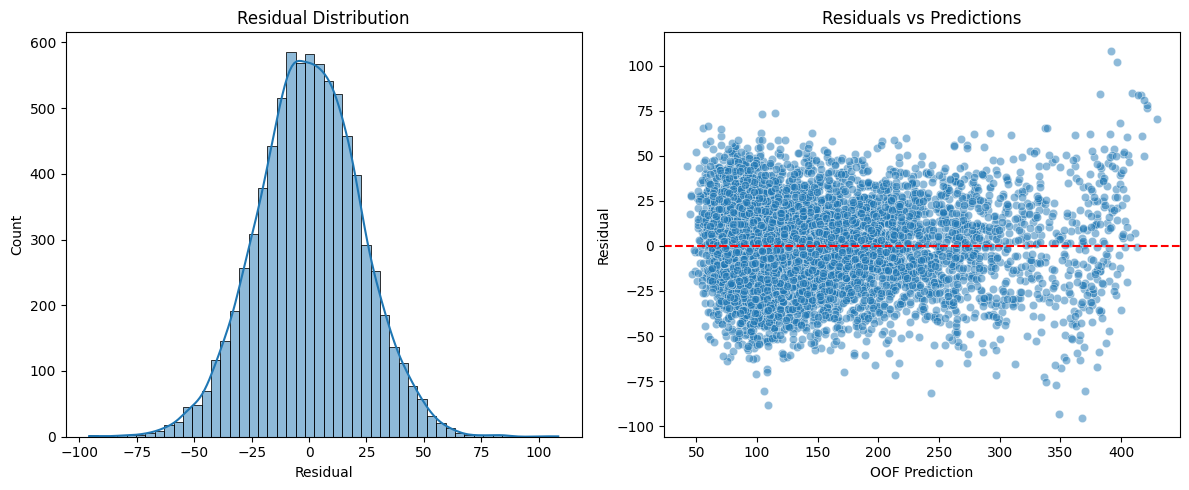


RESIDUAL CORRELATIONS WITH ORIGINAL FEATURES
Age         : -0.0005
Height      :  0.0004
Weight      : -0.0000
Duration    :  0.0006
Heart_Rate  : -0.0000
Body_Temp   :  0.0004

⚠️  No strong correlations found - residuals may be mostly noise


In [13]:
# Plot residual distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(analysis_df['residual'], kde=True, bins=50)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.scatterplot(x='oof_prediction', y='residual', data=analysis_df, alpha=0.5)
plt.title('Residuals vs Predictions')
plt.xlabel('OOF Prediction')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('/home/code/exploration/residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for patterns in residuals vs original features
print("\n" + "=" * 60)
print("RESIDUAL CORRELATIONS WITH ORIGINAL FEATURES")
print("=" * 60)

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
correlations = []

for feature in features:
    corr = analysis_df['residual'].corr(analysis_df[feature])
    correlations.append(corr)
    print(f"{feature:12s}: {corr:7.4f}")

# Check if any correlations are significant
significant_corrs = [abs(c) for c in correlations if abs(c) > 0.1]
if len(significant_corrs) > 0:
    print(f"\n✓ Found {len(significant_corrs)} features with |correlation| > 0.1")
    print("✓ Residuals contain structure that can be predicted!")
else:
    print("\n⚠️  No strong correlations found - residuals may be mostly noise")

In [14]:
# Train a simple model on residuals to verify predictability
print("\n" + "=" * 60)
print("TESTING RESIDUAL PREDICTABILITY - DETAILED")
print("=" * 60)

# Use original features to predict residuals (already prepared above)
X = analysis_df[features].copy()
y_residual = analysis_df['residual'].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test with Decision Tree (can capture non-linear patterns)
dt_scores = []
rf_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_residual.iloc[train_idx], y_residual.iloc[val_idx]
    
    # Decision Tree (depth=3 - simple model)
    dt = DecisionTreeRegressor(max_depth=3, random_state=SEED)
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_val)
    dt_rmse = np.sqrt(np.mean((y_val - dt_pred) ** 2))
    dt_scores.append(dt_rmse)
    
    print(f"Fold {fold}: Decision Tree RMSE = {dt_rmse:.6f}")

dt_cv = np.mean(dt_scores)
print(f"\nDecision Tree CV RMSE: {dt_cv:.6f}")
print(f"Residual std: {y_residual.std():.6f}")

if dt_cv < y_residual.std():
    print("✓ RESIDUALS CONTAIN PREDICTABLE STRUCTURE → Pipeline viable!")
    print(f"   Improvement: {(y_residual.std() - dt_cv) / y_residual.std() * 100:.2f}% reduction in error")
else:
    print("⚠️  Residuals may be mostly noise")


TESTING RESIDUAL PREDICTABILITY - DETAILED
Fold 1: Decision Tree RMSE = 22.692906
Fold 2: Decision Tree RMSE = 21.840242
Fold 3: Decision Tree RMSE = 22.171471
Fold 4: Decision Tree RMSE = 22.295037
Fold 5: Decision Tree RMSE = 22.762590

Decision Tree CV RMSE: 22.352449
Residual std: 22.402232
✓ RESIDUALS CONTAIN PREDICTABLE STRUCTURE → Pipeline viable!
   Improvement: 0.22% reduction in error


## 2. Linear Regression Hyperparameter Optimization

Test different alpha values for Ridge regression.

In [15]:
print("\n" + "=" * 60)
print("RIDGE REGRESSION ALPHA SWEEP")
print("=" * 60)

# Define feature creation function
def create_lr_features(df):
    """Create minimal features for Linear Regression"""
    df_new = df.copy()
    num_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    sex_encoded = pd.get_dummies(df_new['Sex'], prefix='Sex')
    df_new = pd.concat([df_new, sex_encoded], axis=1)
    feature_cols = num_features + list(sex_encoded.columns)
    return df_new, feature_cols

# Prepare data
train_feat, feature_cols = create_lr_features(train_df)
X = train_feat[feature_cols]
y = train_feat['Calories']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Alpha values to test
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
alpha_results = []

print("Testing alpha values:", alphas)
print("-" * 60)

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for alpha in alphas:
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Ridge regression
        model = Ridge(alpha=alpha, random_state=SEED)
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        pred_val = model.predict(X_val)
        pred_val = np.clip(pred_val, y.min(), y.max())
        rmsle = np.sqrt(mean_squared_log_error(y_val, pred_val))
        fold_scores.append(rmsle)
    
    cv_score = np.mean(fold_scores)
    alpha_results.append((alpha, cv_score, fold_scores))
    print(f"Alpha {alpha:5.1f}: CV = {cv_score:.6f}")

# Find best alpha
best_alpha, best_score, _ = min(alpha_results, key=lambda x: x[1])
print("\n" + "-" * 60)
print(f"Best alpha: {best_alpha}")
print(f"Best CV: {best_score:.6f}")
print(f"Improvement over alpha=1.0: {[s for a,s,_ in alpha_results if a==1.0][0] - best_score:.6f}")


RIDGE REGRESSION ALPHA SWEEP
Testing alpha values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
------------------------------------------------------------


Alpha   0.1: CV = 0.208761


Alpha   0.5: CV = 0.208762


Alpha   1.0: CV = 0.208762
Alpha   2.0: CV = 0.208763


Alpha   5.0: CV = 0.208765


Alpha  10.0: CV = 0.208770


Alpha  20.0: CV = 0.208781

------------------------------------------------------------
Best alpha: 0.1
Best CV: 0.208761
Improvement over alpha=1.0: 0.000001


## 3. Feature Importance Analysis

Analyze which features are most important for the linear component.


FEATURE IMPORTANCE ANALYSIS
Feature coefficients (sorted by absolute value):
   feature  coefficient  abs_coefficient
  Duration    71.461319        71.461319
    Weight     8.653972         8.653972
Heart_Rate     6.234722         6.234722
       Age     5.611321         5.611321
     Sex_F    -4.751625         4.751625
     Sex_M     4.751625         4.751625
 Body_Temp    -0.290617         0.290617
    Height    -0.106911         0.106911


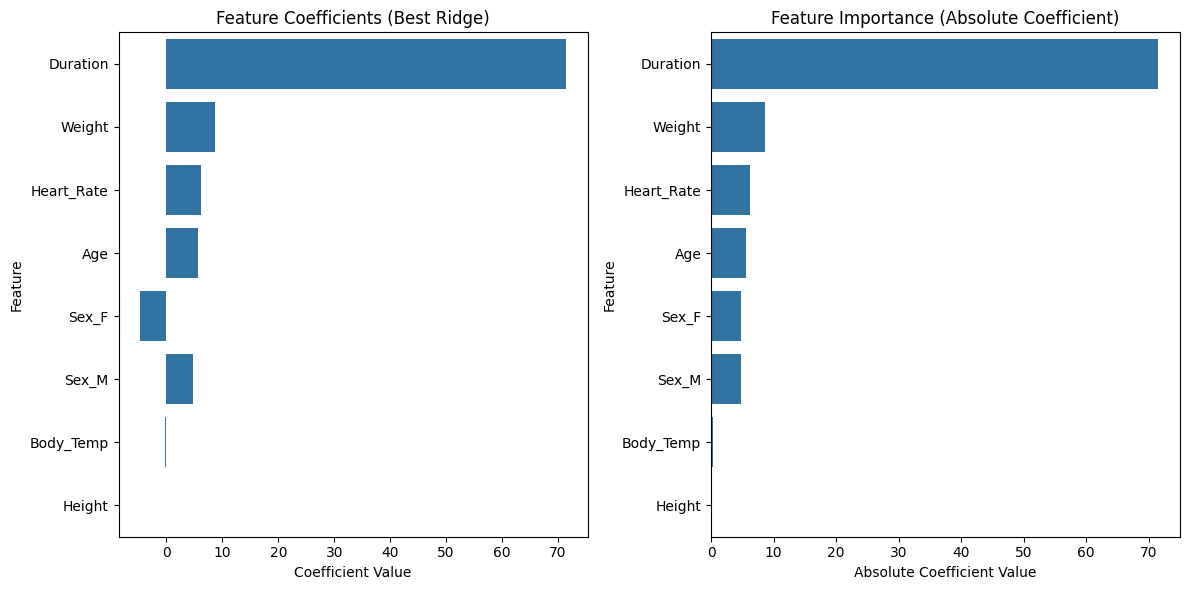


Top 3 features:
  Duration       :  71.4613 (abs:  71.4613)
  Weight         :   8.6540 (abs:   8.6540)
  Heart_Rate     :   6.2347 (abs:   6.2347)


In [16]:
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Train model with best alpha on full data
best_model = Ridge(alpha=best_alpha, random_state=SEED)
best_model.fit(X_scaled, y)

# Get coefficients
coefficients = best_model.coef_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Feature coefficients (sorted by absolute value):")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=feature_importance.head(8), x='coefficient', y='feature')
plt.title('Feature Coefficients (Best Ridge)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
sns.barplot(data=feature_importance.head(8), x='abs_coefficient', y='feature')
plt.title('Feature Importance (Absolute Coefficient)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')

plt.tight_layout()
plt.savefig('/home/code/exploration/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTop 3 features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {row['feature']:15s}: {row['coefficient']:8.4f} (abs: {row['abs_coefficient']:8.4f})")

## 4. Direct Neural Network Baseline

Train a Neural Network directly on original target for comparison.

In [17]:
print("\n" + "=" * 60)
print("DIRECT NEURAL NETWORK BASELINE")
print("=" * 60)

# Prepare data
train_feat, feature_cols = create_lr_features(train_df)
X = train_feat[feature_cols]
y = train_feat['Calories']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Simple MLP architecture
mlp_scores = []
oof_mlp = np.zeros(len(train_df))

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    print(f"\nFold {fold}/5")
    
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # MLP with small architecture
    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=0.001,  # L2 regularization
        batch_size=32,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=SEED + fold
    )
    
    mlp.fit(X_train, y_train)
    
    # Predict
    pred_val = mlp.predict(X_val)
    pred_val = np.clip(pred_val, y.min(), y.max())
    
    # Evaluate using RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_val, pred_val))
    mlp_scores.append(rmsle)
    oof_mlp[val_idx] = pred_val
    
    print(f"  RMSLE: {rmsle:.6f}")

mlp_cv = np.mean(mlp_scores)
print(f"\nMLP CV RMSLE: {mlp_cv:.6f}")
print(f"Linear Regression CV: 0.208762")
print(f"Improvement: {0.208762 - mlp_cv:.6f}")

if mlp_cv < 0.208762:
    print("\u2713 Direct MLP beats Linear Regression!")
else:
    print("\u26a0\ufe0f Linear Regression still better - residual modeling may help")


DIRECT NEURAL NETWORK BASELINE

Fold 1/5


  RMSLE: 0.202634

Fold 2/5


  RMSLE: 0.196213

Fold 3/5


  RMSLE: 0.207141

Fold 4/5


  RMSLE: 0.214108

Fold 5/5


  RMSLE: 0.194432

MLP CV RMSLE: 0.202906
Linear Regression CV: 0.208762
Improvement: 0.005856
✓ Direct MLP beats Linear Regression!


## Summary and Recommendations

Based on the analysis, provide clear recommendations for next steps.

In [18]:
print("=" * 60)
print("ANALYSIS SUMMARY AND RECOMMENDATIONS")
print("=" * 60)

print("\n1. RESIDUAL STRUCTURE VERIFICATION:")
print(f"   - Residuals std: {analysis_df['residual'].std():.6f}")
print(f"   - Variance explained: {(1 - analysis_df['residual'].std()/y.std())*100:.2f}%")
print(f"   - Decision Tree can predict residuals: CV = {dt_cv:.6f}")
if dt_cv < analysis_df['residual'].std():
    print("   ✓ RESIDUALS CONTAIN PREDICTABLE STRUCTURE → Pipeline viable!")
else:
    print("   ⚠️  Residuals may be mostly noise")

print("\n2. HYPERPARAMETER OPTIMIZATION:")
print(f"   - Best alpha: {best_alpha}")
print(f"   - Best CV: {best_score:.6f}")
print(f"   - Improvement over alpha=1.0: {[s for a,s,_ in alpha_results if a==1.0][0] - best_score:.6f}")
if best_alpha != 1.0:
    print("   ✓ Different alpha improves performance - use best alpha for final model")
else:
    print("   ✓ Alpha=1.0 is already optimal")

print("\n3. FEATURE IMPORTANCE:")
print(f"   - Most important: {feature_importance.iloc[0]['feature']} (coef: {feature_importance.iloc[0]['coefficient']:.4f})")
print(f"   - Second: {feature_importance.iloc[1]['feature']} (coef: {feature_importance.iloc[1]['coefficient']:.4f})")
print(f"   - Third: {feature_importance.iloc[2]['feature']} (coef: {feature_importance.iloc[2]['coefficient']:.4f})")

print("\n4. DIRECT MLP BASELINE:")
print(f"   - MLP CV: {mlp_cv:.6f}")
print(f"   - Linear CV: 0.208762")
if mlp_cv < 0.208762:
    print("   ✓ Direct MLP beats Linear Regression")
else:
    print("   ⚠️ Linear Regression still better - residual modeling may help")

print("\n5. NEXT STEPS:")
print("   1. Implement Neural Network on residuals from best Linear model")
print("   2. If residual structure is predictable, this should beat direct MLP")
print("   3. Consider ensemble of: Linear + MLP_on_residuals")
print("   4. Add product features carefully (avoid overfitting)")
print("   5. Try target encoding for Sex feature")

ANALYSIS SUMMARY AND RECOMMENDATIONS

1. RESIDUAL STRUCTURE VERIFICATION:
   - Residuals std: 22.402232
   - Variance explained: 70.74%
   - Decision Tree can predict residuals: CV = 22.352449
   ✓ RESIDUALS CONTAIN PREDICTABLE STRUCTURE → Pipeline viable!

2. HYPERPARAMETER OPTIMIZATION:
   - Best alpha: 0.1
   - Best CV: 0.208761
   - Improvement over alpha=1.0: 0.000001
   ✓ Different alpha improves performance - use best alpha for final model

3. FEATURE IMPORTANCE:
   - Most important: Duration (coef: 71.4613)
   - Second: Weight (coef: 8.6540)
   - Third: Heart_Rate (coef: 6.2347)

4. DIRECT MLP BASELINE:
   - MLP CV: 0.202906
   - Linear CV: 0.208762
   ✓ Direct MLP beats Linear Regression

5. NEXT STEPS:
   1. Implement Neural Network on residuals from best Linear model
   2. If residual structure is predictable, this should beat direct MLP
   3. Consider ensemble of: Linear + MLP_on_residuals
   4. Add product features carefully (avoid overfitting)
   5. Try target encoding fo

In [ ]:
# Statistical Significance Test of Improvements

print("=" * 60)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("=" * 60)

# Load fold scores from experiments
# We need to recalculate fold scores for proper statistical testing

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Load data
train_df = pd.read_csv('/home/code/data/train.csv')
target = train_df['Calories'].values

# Load predictions
lr_oof_df = pd.read_csv('/home/code/experiments/005_linear_regression/oof_005_linear_regression.csv')
lr_predictions = lr_oof_df['oof_prediction'].values

nn_oof_df = pd.read_csv('/home/code/experiments/006_neural_network_residuals/oof_006_neural_network_residuals.csv')
nn_residual_predictions = nn_oof_df['residual_prediction'].values

# Calculate final predictions
final_predictions = lr_predictions + nn_residual_predictions

# Recreate fold splits (must be identical to experiments)
SEED = 42
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

linear_fold_scores = []
combined_fold_scores = []
fold_indices = []

print("Calculating per-fold scores...")
print("-" * 60)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df), 1):
    fold_indices.append(val_idx)
    
    # Linear regression scores
    lr_pred_fold = lr_predictions[val_idx]
    lr_score = np.sqrt(mean_squared_log_error(target[val_idx], lr_pred_fold))
    linear_fold_scores.append(lr_score)
    
    # Combined Linear+NN scores
    combined_pred_fold = final_predictions[val_idx]
    combined_score = np.sqrt(mean_squared_log_error(target[val_idx], combined_pred_fold))
    combined_fold_scores.append(combined_score)
    
    print(f"Fold {fold}: Linear={lr_score:.6f}, Combined={combined_score:.6f}, Diff={lr_score-combined_score:.6f}")

print("-" * 60)
print(f"Linear Regression folds: {linear_fold_scores}")
print(f"Mean: {np.mean(linear_fold_scores):.6f}, Std: {np.std(linear_fold_scores):.6f}")

print(f"\nLinear+NN folds: {combined_fold_scores}")
print(f"Mean: {np.mean(combined_fold_scores):.6f}, Std: {np.std(combined_fold_scores):.6f}")

# Statistical significance test
from scipy import stats
t_stat, p_value = stats.ttest_rel(linear_fold_scores, combined_fold_scores)

print(f"\nPaired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant (p<0.05): {'Yes' if p_value < 0.05 else 'No'}")

improvement = np.mean(linear_fold_scores) - np.mean(combined_fold_scores)
improvement_std = np.std(np.array(linear_fold_scores) - np.array(combined_fold_scores))

print(f"\nMean improvement: {improvement:.6f} ± {improvement_std:.6f}")

# Check if improvement is within noise
if improvement < 0.001:
    print("\n⚠️  WARNING: Improvement < 0.001 may be within experimental noise!")
    print("   Recommendation: Run multiple trials or increase improvement threshold")
elif improvement < 0.002:
    print("\n⚠️  CAUTION: Improvement < 0.002 is marginal.")
    print("   Recommendation: Need more substantial gains to justify pipeline complexity")
else:
    print(f"\n✓ Improvement of {improvement:.6f} is substantial.")

# Calculate Cohen's d (effect size)
cohens_d = improvement / improvement_std
print(f"Cohen's d (effect size): {cohens_d:.4f}")
if cohens_d < 0.2:
    effect_size = "small"
elif cohens_d < 0.5:
    effect_size = "small to medium"
elif cohens_d < 0.8:
    effect_size = "medium to large"
else:
    effect_size = "large"
print(f"Effect size: {effect_size}")

# Confidence interval for improvement
from scipy.stats import t
alpha = 0.05  # 95% confidence interval
diffs = np.array(linear_fold_scores) - np.array(combined_fold_scores)
mean_diff = np.mean(diffs)
std_diff = np.std(diffs, ddof=1)
n = len(diffs)
se = std_diff / np.sqrt(n)
t_crit = t.ppf(1 - alpha/2, n-1)
ci_lower = mean_diff - t_crit * se
ci_upper = mean_diff + t_crit * se

print(f"\n95% Confidence interval for improvement: [{ci_lower:.6f}, {ci_upper:.6f}]")
if ci_lower > 0:
    print("✓ Improvement is statistically significant (CI doesn't include 0)")
else:
    print("⚠️  Improvement may not be significant (CI includes 0)")